# Source Terms
## The Poisson Equation

Now that we have a fast efficient solver for the Laplace equation, we can start to consider the non-homogeneous case:

$$\nabla^2 u=f(x,y).$$

Which is know as the Poisson equation.  It is named after the French physisit Baron Siméon Denis Poisson, FRS FRSE.  Who is suposed to have said "Life is good for only two things: doing mathematics and teaching it."

There are many situations in which we want to solve this equation and the good news is that we can use the methods we developed for solving the Laplace equation,

$$\nabla^2 u=0,$$

by making appropriate changes to the RHS vector __b__.

## Deflection of a rubber sheet

We are going to consider the deformation of a two dimensional rubber sheet subjected to a point load. The governing equation is

$$-T\nabla^2D = p$$

where D(x,y) is the deflection of the sheet, T is the (constant) tension and p(x,y) is the applied load. At the boundary of the sheet D=0. The local load is given by

$$p(x,y)=\frac{A}{2\pi\sigma}\exp(−\frac{1}{2}\left(\frac{x−x0}{\sigma}\right)^2−\frac{1}{2}\left(\frac{y−y0}{\sigma}\right)^2).$$

The parameter A is the amplitude of the pressure applied at the point (x0,y0). The parameter σ represents the “width” of the applied load.

## The Grid Class (with a RHS)
We are going to modify the Grid class so that a grid also contains values of the RHS function <code>f(x,y)</code>.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        # and the f values for the RHS of the equation
        self.f = np.zeros((nj, ni))
        
        # boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
            
    def set_RHS_values(self,func):
        '''fill in the RHS values based on the x and y of each grid point.
        The user defined function func is called with the x and y arrays.'''
        self.f=func(self.x,self.y)
    
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)
        boundaries = self.report_BC()
        return describe + '\nBoundaries conditions are - ' + boundaries

## Test problem

We can simplify things by introducing dimensionless coordinates _x_<sup>*</sup>=_x/R_ and  _y_<sup>*</sup>=_y/R_.  We can make the deflection a dimensionless quantity _w_=_D_/_D_<sub>c</sub>, where _D_<sub>c</sub> is the characteristic size of the deflection.  Placing the location at which the force is applied at a point (0, _R_<sup>*</sup>) we obtain

$$\frac{\partial^2 w}{\partial x^2}+\frac{\partial^2 w}{\partial y^2}=-\alpha\exp\left[-\beta^2\left(x^2+(y-R^*)^2\right)\right].$$

were
$$\alpha = \frac{R^2A}{2\pi TD_c\sigma}\ \mathrm{and}\ \beta=\frac{R}{\sqrt{2}\sigma}.$$

Choosing ⍺=4.0, β=8.0 and _R_<sup>*</sup>=0.6 and solving over the domain _x_<sup>*</sup>, _y_<sup>*</sup> ∈ [-1, 1]. Gives us our test problem.


Uniform 61x61 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.


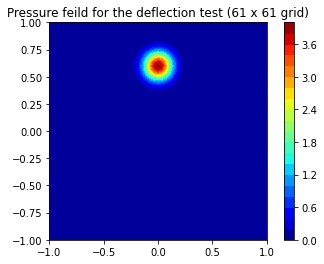

In [2]:
def pressure(x,y):
    '''calculate the pressure at the points (x,y) using the rubber sheet
    test problem equation 
    $$p = -\alpha\exp\left[-\beta^2\left(x^2+(y-R^*)^2\right)\right]$$
    with beta = 8, R*=0.6 and alpha=4.0.
    '''
    beta = 8.0
    alpha= 4.0
    R_star = 0.6
    return alpha*np.exp(-beta**2*(x**2+(y-R_star)**2))

def DeflectionTest(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_origin(-1.0,-1.0)
    mesh.set_extent(1.0,1.0)
    mesh.generate()
    # mesh objects defaults to Dirichlet BC on all sides.
    mesh.u[:,:]=0.0
    # calculate the RHS
    mesh.set_RHS_values(pressure)
    return mesh

test = DeflectionTest(61,61)
print(test)

fig, ax1 = plt.subplots()
ax1.set_aspect('equal')
cmap = plt.get_cmap('jet')
cf = ax1.contourf(test.x,test.y,test.f,cmap=cmap,levels = 21)
fig.colorbar(cf, ax=ax1)
ax1.set_title(f'Pressure feild for the deflection test ({test.Ni} x {test.Nj} grid)')
plt.show()


## Poisson Solver

We start with the Laplace solver from the last worksheet. This is using the bi-conjugate gradient solver with the incomplete LU factorisation as a pre-condiioer.

The key change here is to adjust the calculation of the RHS vector __b__ so that it the value of the function _f_ is added to each of the _b_<sub></sub> values.  We need to multiply the value of _f_ by Δx and Δy so that the contibution is scaled properly.  To see why derive the finite difference approximation for the Poisson equation!


In [3]:
import scipy.sparse.linalg as LA
import scipy.sparse as sps

def PoissonSolver(grid,tol=0.5e-7):
    '''Solve the two dimensional Poisson equation using the bi-conjugate
    gradient stabilised matrix solver (BiCGStab).  This function assembles
    the coeficient matrix A and the RHS vector b taking account of the 
    boundary conditions specified in the grid object and calls the sparse
    BiCGStab solver from scipy.  The value tol is passed to BiCGStab routine
    The solution vector x is then unpacked into grid.u. It returns the info
    value from BiCGStab if this is zero everything worked.
    
    Writen by D Ingram
    (c) 2021 The University of Edinburgh
    Licenced CC-BY.
    '''
    
    # Create the A matrix using the lil format and the b vector
    # as numpy vector.
    N = (grid.Nj-2)*(grid.Ni-2)
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)

    # calculate the coefficients
    beta = grid.Delta_x()/grid.Delta_y()
    beta_sq = beta**2
    R_x = - 1/(2*(1+beta_sq))
    R_y = beta_sq * R_x
    # the last coefficient is the multiplier for the Poisson term.
    R_f = grid.Delta_x()*grid.Delta_y()

    # matrix assembly. We're going to use += to add values to the matrix
    # coeeficients and the RHS vector as boundary conditions could cause
    # issues.  This is safe to do because both np.zeros and the sparse
    # matrix creator initialise the values in the arrays to zero.
    for j in range(1, grid.Nj-1):
        for i in range(1, grid.Ni-1):
            k = (i-1) + (grid.Ni-2)*(j-1)
            A_mat[k,k]=1
        
            # Left boundary
            if i>1:
                A_mat[k,k-1] += R_x
            elif (grid.BC[0] == grid.NEUMANN_BC):
                A_mat[k,k+1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i-1]

            # Right boundary
            if i<grid.Ni-2:
                A_mat[k,k+1] +=R_x
            elif (grid.BC[1] == grid.NEUMANN_BC):
                A_mat[k,k-1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i+1]
            
            # Bottom boundary
            if j>1:
                A_mat[k,k-(grid.Ni-2)] += R_y
            elif (grid.BC[3]== grid.NEUMANN_BC):
                A_mat[k,k+(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j-1,i]
   
            # South boundary
            if j<grid.Nj-2:
                A_mat[k,k+(grid.Ni-2)] += R_y
            elif (grid.BC[2]== grid.NEUMANN_BC):
                A_mat[k,k-(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j+1,i]
                
            #Now add the value of f(x,y) to the RHS value b
            b_vec[k] += R_f*grid.f[j,i]

    # call bicgstab with an ILU preconditioner, drop_tol and
    # fill factor control the accuracy of the ILU approximation.
    ilu = LA.spilu(A_mat.tocsc(), drop_tol=1e-6, fill_factor=100)
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)
    x_vec, info = LA.bicgstab(A_mat,b_vec,atol=tol,M=M_mat)

    if info<=0:
        # unpack x_vec into u
        for j in range(1, grid.Nj-1):
            for i in range(1, grid.Ni-1):
                k = (i-1) + (grid.Ni-2)*(j-1)
                grid.u[j,i]=x_vec[k]
    
    return info


## Test
Let's test it.  We will plot the 2D solutions when we've done and also plot a graph of the centerline of the dsiplacement and pressure feilds.


Uniform 121x121 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
Solver took 0.451 seconds.


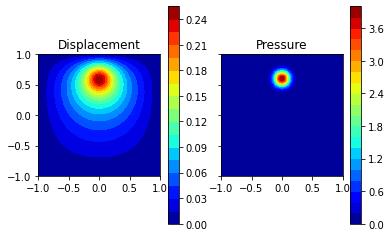

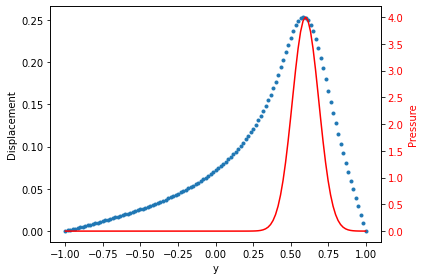

In [4]:
test = DeflectionTest(121,121)
print(test)

# run the solver
start = time.process_time()
info = PoissonSolver(test)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))

if info==0:
    # plot the solution# create two subplots with the shared x and y axes
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    
    # Plot the deflecton
    cmap = plt.get_cmap('jet')
    cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap,levels = 21)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title(f'Displacement')
    # Plot the pressure
    cf = ax2.contourf(test.x,test.y,test.f,cmap=cmap,levels = 21)
    fig.colorbar(cf, ax=ax2)
    ax2.set_title(f'Pressure')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')
    
# plot the deflection on the centerline and the pressure
X_c = int(test.Ni / 2)
fig, ax1 = plt.subplots()
ax1.set_xlabel('y')
ax1.set_ylabel('Displacement')
ax1.plot(test.y[:,X_c],test.u[:,X_c],'.')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Pressure',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.plot(test.y[:,X_c],test.f[:,X_c],'r')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# final test

Now we have a working Poisson solver we need to do the traditional mesh refinement test.

We need an integrated quanity to calculate.  We're going to use the $$\int_{-1}^{1}u(0.0,y)\ dy$$ as the measure. effectively using the area under the displacement curev plotted above as the measure of the integrated quantity.

In [5]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dy(mesh,y0,y1,x):
    '''Calculate U=\int_{y0}^{y1)u(0,y) dy  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i,j0 = mesh.find((x,y0))
    i,j1 = mesh.find((x,y1))

    # add 1 to i1 as we are going to use it as an upper 
    # bound forarray slicing
    j1 = j1 +1
    
    # integrate
    return integrate.simps(mesh.u[j0:j1,i],mesh.y[j0:j1,i])



In [6]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(7,1,-1):
    ni = 10*2**grid_index + 1
    nj = 10*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    test = DeflectionTest(ni,nj)
    print(test)
    
    # Solve the problem using floating point epsilon as
    # the tolerance for convergence.
    start = time.process_time()
    info = PoissonSolver(test,tol=np.finfo(float).eps)
    stop = time.process_time()
    print("The solver took {}, the return code is {}" \
          .format(datetime.timedelta(seconds=int(stop-start)),info))

    # save dx and the integral
    dx_val.append(test.Delta_x())
    U_val.append(integrate_u_dy(test,-1.0,1.0,0.0))
    run_time.append(stop-start)
          
    print('Integrated value is ',U_val[-1],'\n')

Uniform 1281x1281 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:07:18, the return code is 0
Integrated value is  0.17146915487654404 

Uniform 641x641 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:22, the return code is 0
Integrated value is  0.17145808153289382 

Uniform 321x321 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:03, the return code is 0
Integrated value is  0.1714820585102818 

Uniform 161x161 grid from (-1.0, -1.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:00, the return code is 0
Integrated value is  0.17151013554673716 

Uniform 81x81 grid from (-1.0, -1.0

Refinement Analysis on 6 grids.

Grid Delta x ratio  \int_{0.5}^{0.7}w(0,y) dy
---------------------------------------------
   1 0.001563     2  0.171469
   2 0.003125     2  0.171458
   3 0.00625     2  0.171482
   4  0.0125     2   0.17151
   5   0.025     2   0.17053
   6    0.05   ---  0.167722
--------------------------------------------- 

order of convergence, p =   1.11

Grids       GCI
---------------
 1  2 6.927e-05
 2  3   0.00015
 3  4 0.0001756
 4  5   0.00613
 5  6   0.01767
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3      0.9999 True
 2 3  3 4       1.849 False
 3 4  4 5     0.06204 False
 4 5  5 6      0.7513 False
-------------------------------



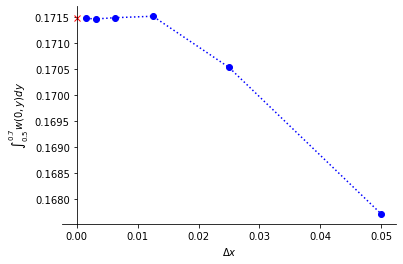

In [7]:
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'\int_{0.5}^{0.7}w(0,y) dy')
analysis.plot(True,r'$\int_{0.5}^{0.7}w(0,y) dy$')

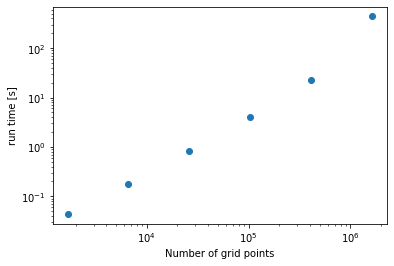

In [8]:
# Plot the runtime
plt.plot(n_pts,run_time,'o')
plt.ylabel('run time [s]')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of grid points')
plt.show()


##### Analysis
The runtime for preconditioned BiCGStab on the 1281 x 1281 grid is 07:23.  The GCI analysis shows that the apparent order is 1.11 (so less than 2) but that the three finest grids are mesh converged.  The plot shows that the integrated quanity is approaching the limit anymptotically.  

Seven minutes is a perfectly respectable runtime for solving this problem but requires some degree of patients (and perhsps making a cup of coffee).  The 641 x 641 grid takes about 22 seconds and still gives a good solution.  Plotting the log of the solution time against the log of the number of grid points shows an almost linear rationship.

The slope of this line can be found by regression.



Time to solution is approximately 2.1e-06⨉N^1.3 seconds.
The regression line explains 99% of the variation


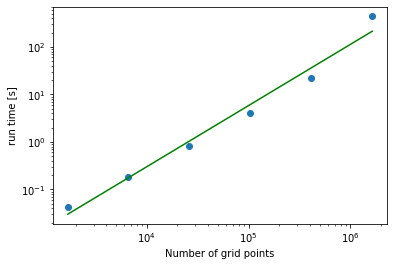

In [9]:
from scipy import stats

# log-log regression using the scipy stats library
log_n = np.log(n_pts)
log_t = np.log(run_time)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_n,log_t)

# plot the results
print('Time to solution is approximately {:.3g}⨉N^{:.1f} seconds.'.format(np.exp(intercept),slope)) 
print('The regression line explains {:.0f}% of the variation'.format(100*r_value))

# plot the regression line
plt.plot(n_pts,run_time,'o')
plt.plot(n_pts,np.exp(intercept)*n_pts**slope,'g-')
plt.ylabel('run time [s]')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of grid points')
plt.show()



## Runtime
Remember that _N_ is the total number of grid points, i.e. _N_=_N_<sub>x</sub> ⨉ _N_<sub>y</sub>.  

Since _N_ is approximately _N_<sub>x</sub><sup>2</sup> and 1.3 is approximately 1, we say that the computational cost of running the BiCGStab solver is roughly N<sup>2</sup>,  i.e. doubling the number of mesh points in erach direction quadrouples the run time.

For a finite difference solver this is exceptionally fast!